In [11]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from matplotlib import pyplot as plt

from UQpy.scientific_machine_learning.neural_networks import DeepOperatorNetwork
from UQpy.scientific_machine_learning.trainers import Trainer
from dataset_pod import load_data, rescale
from scipy.io import savemat

import logging

logger = logging.getLogger("UQpy")
logger.setLevel(logging.INFO)

In [12]:
class BranchNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.fnn = nn.Sequential(nn.Linear(101, 100), nn.Tanh())
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, (5, 5), padding="same"),
            nn.AvgPool2d(2, 1, padding=0),
            nn.Conv2d(16, 16, (5, 5), padding="same"),
            nn.AvgPool2d(2, 1, padding=0),
            nn.Conv2d(16, 16, (5, 5), padding="same"),
            nn.AvgPool2d(2, 1, padding=0),
            nn.Conv2d(16, 64, (5, 5), padding="same"),
            nn.AvgPool2d(2, 1, padding=0),
        )
        self.dnn = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 6 * 6, 512),
            nn.Tanh(),
            nn.Linear(512, 512),
            nn.Tanh(),
            nn.Linear(512, 200),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fnn(x)
        x = x.view(-1, 1, 10, 10)
        x = self.conv_layers(x)
        x = self.dnn(x)
        return x


In [13]:
class TrunkNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    @staticmethod
    def forward(x: torch.Tensor) -> torch.Tensor:
        return x


branch_network = BranchNet()
trunk_network = TrunkNet()
model = DeepOperatorNetwork(branch_network, trunk_network, 2)


class ElasticityDataSet(Dataset):
    """Load the Elasticity dataset"""

    def __init__(self, x_basis, y_basis, f_x, u_x, u_y):
        self.u_basis = np.hstack((x_basis, y_basis))
        self.f_x = f_x
        self.u_x = u_x
        self.u_y = u_y

    def __len__(self):
        return int(self.f_x.shape[0])

    def __getitem__(self, i):
        return self.u_basis, self.f_x[i, :], (self.u_x[i, :, 0], self.u_y[i, :, 0])

In [14]:
modes = 100
(F_train, Ux_train, Uy_train, F_test, Ux_test, Uy_test, X,
 ux_train_mean, ux_train_std, uy_train_mean, uy_train_std,
 ux_basis, uy_basis, lam_ux, lam_uy) = load_data(modes)
train_data = DataLoader(
    ElasticityDataSet(
        np.float32(ux_basis), np.float32(uy_basis), np.float32(F_train), np.float32(Ux_train), np.float32(Uy_train)
    ),
    batch_size=100,
    shuffle=True,
)
test_data = DataLoader(
    ElasticityDataSet(
        np.float32(ux_basis), np.float32(uy_basis), np.float32(F_test), np.float32(Ux_test), np.float32(Uy_test)
    ),
    batch_size=100,
    shuffle=True,
)


In [15]:
class LossFunction(nn.Module):
    def __init__(self, reduction: str = "mean", *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.reduction = reduction

    def forward(self, prediction, label):
        return F.mse_loss(
            prediction[0], label[0], reduction=self.reduction
        ) + F.mse_loss(prediction[1], label[1], reduction=self.reduction)

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
trainer = Trainer(model, optimizer, LossFunction())

In [17]:
trainer.run(train_data=train_data, test_data=test_data, epochs=100, tolerance=1e-4)

[INFO] - 2024-05-16 12:48:41,638 - UQpy: Scientific Machine Learning: Beginning training and testing DeepOperatorNetwork
[INFO] - 2024-05-16 12:48:42,643 - UQpy: Scientific Machine Learning: Epoch 1 / 100 Train Loss 118.38151871530633 Test Loss 52.60863494873047
[INFO] - 2024-05-16 12:48:43,430 - UQpy: Scientific Machine Learning: Epoch 2 / 100 Train Loss 13.512471500195955 Test Loss 3.0186781883239746
[INFO] - 2024-05-16 12:48:44,213 - UQpy: Scientific Machine Learning: Epoch 3 / 100 Train Loss 2.1605661291825142 Test Loss 2.577214002609253
[INFO] - 2024-05-16 12:48:45,008 - UQpy: Scientific Machine Learning: Epoch 4 / 100 Train Loss 2.0400474636178267 Test Loss 2.494576930999756
[INFO] - 2024-05-16 12:48:45,793 - UQpy: Scientific Machine Learning: Epoch 5 / 100 Train Loss 1.9461977670067234 Test Loss 2.478592872619629
[INFO] - 2024-05-16 12:48:46,584 - UQpy: Scientific Machine Learning: Epoch 6 / 100 Train Loss 1.9410154882230257 Test Loss 2.493654251098633
[INFO] - 2024-05-16 12:48:

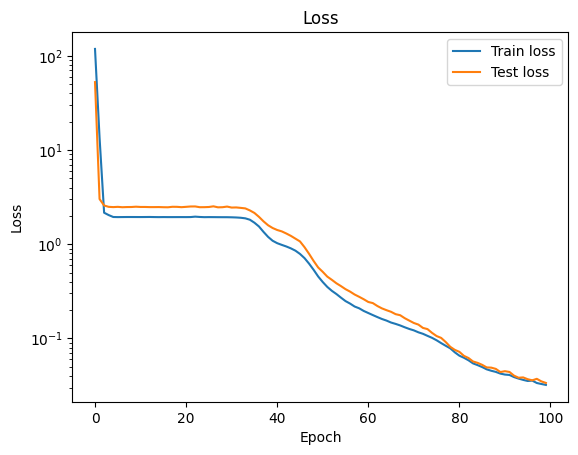

In [18]:
train_loss = trainer.history["train_loss"].detach().numpy()
test_loss = trainer.history["test_loss"].detach().numpy()
fig, ax = plt.subplots()
ax.plot(train_loss, label='Train loss')
ax.plot(test_loss, label='Test loss')
ax.set_title("Loss")
ax.set(xlabel="Epoch", ylabel="Loss")
ax.legend()
ax.set_yscale('log')

In [19]:
# Evaluate test data and save results
def eval_model(test_data, model):
    model.eval()
    ux_pred_list = []
    uy_pred_list = []
    ux_test_list = []
    uy_test_list = []
    x_list = []
    for batch_number, (*x, y) in enumerate(test_data):
        ux_pred, uy_pred = model(*x)
        ux_test, uy_test = y
        ux_pred_list.append(ux_pred)
        uy_pred_list.append(uy_pred)
        ux_test_list.append(ux_test)
        uy_test_list.append(uy_test)
        x_list.append(x[1][:, 0, :])
    return torch.cat(ux_pred_list), torch.cat(uy_pred_list), torch.cat(ux_test_list), torch.cat(
        uy_test_list), torch.cat(x_list)

In [20]:
ux_pred, uy_pred, ux_test, uy_test, x_test = eval_model(test_data, model)
ux_pred = rescale(ux_pred.detach(), np.squeeze(ux_train_mean, axis=2), np.squeeze(ux_train_std, axis=2))
uy_pred = rescale(uy_pred.detach(), np.squeeze(uy_train_mean, axis=2), np.squeeze(uy_train_std, axis=2))
ux_test = rescale(ux_test.detach(), np.squeeze(ux_train_mean, axis=2), np.squeeze(ux_train_std, axis=2))
uy_test = rescale(uy_test.detach(), np.squeeze(uy_train_mean, axis=2), np.squeeze(uy_train_std, axis=2))

savemat('POD_Elastic_plate.mat',
        {'x_test': x_test.detach().numpy(), 'ux_test': ux_test.detach().numpy(), 'uy_test': uy_test.detach().numpy(),
         'ux_pred': ux_pred.detach().numpy(), 'uy_pred': uy_pred.detach().numpy()})
